# L&S 88 - Final Project - Weather and Violent Crimes in Boston
_Notebook created by Masha Paley, Adrienne Kwok, and Katie Robak_

### Table of Contents
1. [Dependences](#Dependencies)
2. [Loading Data](#Loading-Data)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Data Cleaning](#Data-Cleaning)
5. [Hypothesis Test](#Hypothesis-Test)
6. [Test Statistic](#Test-Statistic)
7. [Bootstrap Confidence Interval](#Bootstrap-Confidence-Interval)
8. [Conclusion](#Conclusion)
9. [Sources](#Sources)

### Dependencies
Relevant packages are loaded in the code below.

In [1]:
from datascience import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

### Loading Data
Read in data to notebook from the [Dataverse site](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/4UZ9D4) for the study using the `read_table()` function.

In [3]:
data = Table.read_table("weather_crimes_Boston.csv")

In [4]:
data.show(5)

Date,Day_Wk,nb_crimes,nb_aggravated,nb_simple,nb_vandalism,nb_robbery,nb_larceny,nb_fraud,nb_selected,TEMP,TMAX_C,TMIN_C,DEWP,VISIB,Wind,PRCP,y2012,y2013,y2014,y2015,y2016,y2017,year,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Weekend,DEWP_lag,WDSP_lag,PRCP_lag,TEMP_lag,Season,Summer,Fall,Winter,Spring,heat.index,DayMonth,DayMonth_3,DayMonth1,DayMonth2,DayMonth3,DayMonth1_15_30,LastDayMonth,FirstDayMonth,MidDayMonth,SNOW,Events,Holidays,Snow,Rain,WindxRain,WindxHeatIndex
2012-07-08,Sunday,177,8,19,13,7,31,3,42,26.4444,31.7222,21.7222,15.9444,10,8.5,0,1,0,0,0,0,0,2012,0,0,0,1,0,0,0,1,nan,nan,nan,nan,Summer,1,0,0,0,27,8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,229.5
2012-07-09,Monday,285,6,17,14,7,48,11,37,24.3333,31.7222,20,9.66667,10,7.9,0,1,0,0,0,0,0,2012,0,1,0,0,0,0,0,0,15.9444,8.5,0,26.4444,Summer,1,0,0,0,24,9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,189.6
2012-07-10,Tuesday,263,11,20,15,3,43,10,49,22.7222,28.8889,18.2778,9.66667,10,5.5,0,1,0,0,0,0,0,2012,0,0,0,0,0,1,0,0,9.66667,7.9,0,24.3333,Summer,1,0,0,0,22,10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,121
2012-07-11,Wednesday,246,8,15,17,2,35,4,43,23.1667,28.2778,18.2778,14.5,10,6.7,0,1,0,0,0,0,0,2012,0,0,0,0,0,0,1,0,9.66667,5.5,0,22.7222,Summer,1,0,0,0,23,11,2,0,1,0,0,0,0,0,0,0,0,0,0,0,154.1
2012-07-12,Thursday,251,7,12,22,3,49,9,43,24.5,30,18.8889,15.6111,10,8.6,0,1,0,0,0,0,0,2012,0,0,0,0,1,0,0,0,14.5,6.7,0,23.1667,Summer,1,0,0,0,25,12,2,0,1,0,0,0,0,0,0,0,0,0,0,0,215


---

### Exploratory Data Analysis
Explore data values and create visualizations for relevant variables (`PRCP` and `nb_crimes`).

In [5]:
print("Range of precipitation values:", [np.min(data.column("PRCP")), np.max(data.column("PRCP"))])
print("Range of crime count values:", [np.min(data.column("nb_crimes")), np.max(data.column("nb_crimes"))])

Range of precipitation values: [0.0, 3.54]
Range of crime count values: [110, 343]


In [6]:
rainy_days = data.where("PRCP", are.above(0)).column("nb_crimes")
non_rainy_days = data.where("PRCP", are.equal_to(0)).column("nb_crimes")

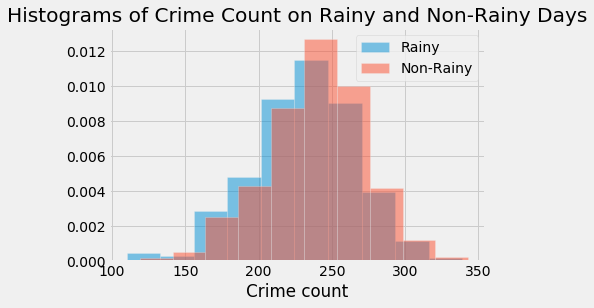

In [7]:
plt.hist(rainy_days, density = True, alpha = 0.5)       # reusing the rainy_days array created above
plt.hist(non_rainy_days, density = True, alpha = 0.5)   # reusing the non_rainy_days array created above
plt.title('Histograms of Crime Count on Rainy and Non-Rainy Days')
plt.xlabel('Crime count')
plt.legend(['Rainy', 'Non-Rainy'])

Based on the above visualization, it looks like our intuition that more crimes occur on non-rainy days is correct. We will test that hypothesis in the rest of the notebook.

---

### Data Cleaning
Select relevant columns from table for precipitation hypothesis test based on background covariates included in original study (see pre-analysis plan in notebooks section of github repo). Desired columns include: `Date`, `Winter`, `Spring`, `Wind`, `SNOW`, `heat.index`, `WindxHeatIndex`, `PRCP`, `Events`, and `nb_crimes`.

In [8]:
cleaned_data = data.select("Date", "nb_crimes", "heat.index", "WindxHeatIndex", "PRCP", "SNOW", "Wind", "Winter", "Spring", "Events")
cleaned_data.show(10)

Date,nb_crimes,heat.index,WindxHeatIndex,PRCP,SNOW,Wind,Winter,Spring,Events
2012-07-08,177,27,229.5,0,0,8.5,0,0,0
2012-07-09,285,24,189.6,0,0,7.9,0,0,0
2012-07-10,263,22,121,0,0,5.5,0,0,0
2012-07-11,246,23,154.1,0,0,6.7,0,0,0
2012-07-12,251,25,215,0,0,8.6,0,0,0
2012-07-13,264,26,275.6,0,0,10.6,0,0,0
2012-07-14,213,27,224.1,0,0,8.3,0,0,0
2012-07-15,235,29,229.1,0,0,7.9,0,0,0
2012-07-16,248,28,268.8,0,0,9.6,0,0,0
2012-07-17,279,30,234,0,0,7.8,0,0,0


In the actual study, matched-sampling strategies were used to create a resample with ideal conditions for a randomized controlled experiment (i.e. a sample where covariate distributions on treatment and control days are similar on average). Because the techniques used to create this resample are beyond the scope of our knowledge, we will skip this step and just use the cleaned dataset above for resampling.

---

### Hypothesis Test

**H<sub>0</sub>** : Precipitation has no effect on the daily violent crime count in Boston.<br/>
**H<sub>A</sub>** : The presence of precipitation decreases the daily violent crime count in Boston.

According to these hypotheses, the treatment group for our experiment includes all days when there was precipitation (i.e. `PRCP` > 1) and the control group includes all days when there was no precipitation (i.e. `PRCP` = 0).

---

### Test Statistic
The test statistic used in the original study was the average exposure effect, denoted `AEE`, defined below.

$$ {AEE}_i = \frac{1}{N}\sum_{i = 1}^{N}Y_i(1) - \frac{1}{N}\sum_{i = 1}^{N}Y_i(0) $$

Since in our simplified replication we did not create a resample with i elements, we will create a slightly different definition for AEE.<br/> 
For our purposes, we will simply compare the average violent crime count on rainy days with the average crime count on non-rainy days.

In [9]:
no_rain = cleaned_data.where("PRCP", are.equal_to(0)).column("nb_crimes")
rain = cleaned_data.where("PRCP", are.above(0)).column("nb_crimes")

In [10]:
no_rain_avg = np.mean(no_rain)
rain_avg = np.mean(rain)
print("average crime count on non-rainy days =", no_rain_avg) 
print("average crime count on rainy days =", rain_avg)

average crime count on non-rainy days = 239.43622200584227
average crime count on rainy days = 230.63622754491018


In order to obtain a value similar to the AEE calculated in the original study, we will calculate the difference in mean crime count between rainy and non-rainy days.

In [11]:
aee = rain_avg - no_rain_avg
aee

-8.799994460932083

---

### Bootstrap Confidence Interval
Calculate a 95% confidence interval using bootstrapping via a for loop.

**Note**: In the original study, resampling was done so that there was an equal chance of a day being part of the control group or treatment group. This is not the case in our replication, since the bootstrapping method we use simply takes a random sample with replacement from the original data set without making any corrections.

In [12]:
n = 1000
size = cleaned_data.num_rows
bootstrap_aee = make_array()

for i in np.arange(n):
    bootstrap_sample = cleaned_data.sample(with_replacement = True)
    no_rain = bootstrap_sample.where("PRCP", are.equal_to(0)).column("nb_crimes")
    rain = bootstrap_sample.where("PRCP", are.above(0)).column("nb_crimes")
    no_rain_avg = np.mean(no_rain)
    rain_avg = np.mean(rain)
    resampled_aee = rain_avg - no_rain_avg
    bootstrap_aee = np.append(bootstrap_aee, resampled_aee)

In [13]:
lower_bound = percentile(2.5, bootstrap_aee)
upper_bound = percentile(97.5, bootstrap_aee)
print("95% Confidence Interval:" ,[lower_bound, upper_bound])

95% Confidence Interval: [-12.121918233158993, -5.345201960215007]


### Conclusion
Since the entire 95% confidence interval for the approximated AEE is a negative range and contains our original estimate, we reject the null hypothesis that the presense of precipitation has no effect on daily violent crime count in Boston.

This conclusion is **the same** as the one that was reached by the [original study.](https://www.nature.com/articles/s41599-018-0188-3#MOESM1)
> The hypothetical experiment focusing on the estimation of the AEE of the occurrence of rainfall suggests that compared to dry days, the average daily violent crimes count decreases by 1.37 (95% posterior interval: [−1.94; −0.79]) during rainy days. In Boston, rainy days have fewer crimes than dry days on average.

Although we reached the same conclusion, our confidence interval does not match up with the interval reported in the original study. The figures in our interval are more negative, indicating a greater effect of precipitation on daily crime count. This can be explained by the fact that the methods we used to obtain our interval were drastically simplified compared to those in the original study. As a result, our test can only confirm whether or not precipitation has an effect on daily crime count and is not reliable for measuring the magnitude of that effect. Our interval is much larger, indicating greater variability in our boostrap samples.

Since we were able to reproduce the same conclusion from the same data using different methods, it appears that the methods and statistics in the original study are sound (at least for the precipitation analysis they conducted). A more advanced replication would be needed in order to confirm if the effect sizes calculated in the original study were accurate.

### Sources
Data 8 Textbook: Confidence Intervals  <br/>
[https://www.inferentialthinking.com/chapters/13/3/Confidence_Intervals.html](https://www.inferentialthinking.com/chapters/13/3/Confidence_Intervals.html)

Sommer, Alice J., Mihye Lee, and Marie-Abèle C. Bind. "Comparing apples to apples: an environmental criminology analysis of the effects of heat and rain on violent crimes in Boston." Palgrave Communications 4.1 (2018): 138. <br/> [https://www.nature.com/articles/s41599-018-0188-3#MOESM1](https://www.nature.com/articles/s41599-018-0188-3#MOESM1)

Sommer, Alice J., Mihye Lee, and Marie-Abèle C. Bind. "Replication Data for: Comparing apples to apples: an environmental criminology analysis of the effects of heat and rain on violent crimes in Boston." Harvard Dataverse (2018). <br/> [https://doi.org/10.7910/DVN/4UZ9D4doi/10.7910/DVN/4UZ9D4](https://doi.org/10.7910/DVN/4UZ9D4doi/10.7910/DVN/4UZ9D4)